In [1]:
# @# markdown codigo é o ticker na B3. Data é ano/mes/dia.

codigo  = 'petr3'       #@param {type:"string"}
inicio  = '2020-01-08'  #@param {type:"date"}
termino = '2022-08-31'  #@param {type:"date"}


usar_periodo = True #@param {type:"boolean"}
periodo = '3y' #@param ['1d','5d','1mo','3mo','6mo','1y','2y','3y','5y','10y','ytd','max']

codigo = codigo.upper()

In [2]:
#@markdown Importação do pacotes do python

import warnings
warnings.filterwarnings('ignore')

import datetime
from datetime import datetime
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm


!pip install -q googletrans==4.0.0rc1
from googletrans import Translator
translator = Translator()
from google.colab import data_table


try:
  import yfinance as yf
except:
  !pip install -q yfinance --upgrade
  import yfinance as yf
try:
  import quandl
except:
  !pip install -q quandl
  import quandl
finally:
  quandl.ApiConfig.api_key = 'XjVtHyrCSxB4xG9iyLUx'
try:
  import investpy as inv
except:
  !pip install -q investpy
  import investpy as inv

import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

#!pip install -q plotly --upgrade
## plotly
import plotly
#import plotly.np.express as px
import plotly.graph_objs as go
import plotly.offline as ply
from plotly.offline import iplot, init_notebook_mode
import seaborn as sns

## cufflinks
import cufflinks as cf
cf.go_offline()
# configurando o plotly para rodar adequadamento no google colab junto com cufflinks
plotly.io.renderers.default = 'colab'

from IPython.display import clear_output 
clear_output()

IBrA = [
    'RRRP3', 'ALPA4', 'ABEV3', 'AMER3', 'ASAI3', 'AZUL4', 'B3SA3', 'BPAN4', 'BBSE3', 'BRML3', 'BBDC3', 
    'BBDC4', 'BRAP4','BBAS3', 'BRKM5', 'BRFS3', 'BPAC11', 'CRFB3', 'CCRO3', 'CMIG4', 'CIEL3', 'COGN3', 
    'CPLE6', 'CSAN3', 'CPFE3', 'CMIN3', 'CVCB3', 'CYRE3', 'DXCO3', 'ECOR3', 'ELET3', 'ELET6', 'EMBR3', 
    'ENBR3', 'ENGI11','ENEV3', 'EGIE3', 'EQTL3', 'EZTC3', 'FLRY3', 'GGBR4', 'GOAU4', 'GOLL4', 'NTCO3', 
    'SOMA3', 'HAPV3', 'HYPE3', 'IGTI11', 'IRBR3','ITSA4','ITUB4', 'JBSS3', 'JHSF3', 'KLBN11', 'RENT3', 
    'LWSA3', 'LREN3', 'MGLU3', 'MRFG3', 'CASH3', 'BEEF3', 'MRVE3', 'MULT3', 'PCAR3', 'PETR3', 'PETR4', 
    'PRIO3', 'PETZ3', 'POSI3', 'QUAL3', 'RADL3', 'RDOR3','RAIL3', 'SBSP3', 'SANB11', 'CSNA3', 'SLCE3', 
    'SULA11', 'SUZB3','TAEE11', 'VIVT3', 'TIMS3', 'TOTS3', 'UGPA3', 'USIM5', 'VALE3','VIIA3', 'VBBR3', 
    'WEGE3', 'YDUQ3', 'NGRD3', 'POSI3' , 'SQIA3' , 'VLID3' 
    ] 

In [3]:
#@markdown A empresa e Indicadores fundamentalistas (de fundamentus.com.br)

try:
  desc = inv.get_stock_company_profile(stock = codigo , country = "Brazil")
except:
  print(codigo)
else:
  result = translator.translate(desc['desc'], dest='pt')
  #print(result.text)
  import textwrap
  print("\n".join(textwrap.wrap(result.text,118)))

import requests
url = 'https://www.fundamentus.com.br/resultado.php'

#pra fingir que é um browser
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

#junta com a requests
r = requests.get(url, headers=header)
# read_html do pandas põe a tabela num dataframe
funds = pd.read_html(r.text, decimal=',', thousands='.')
dfunds = pd.DataFrame(funds[0])

(dfunds.loc[dfunds['Papel']==codigo]).set_index('Papel')

Petrobras Petroleo Brasileiro S.A. Petrobras é especializada na indústria de petróleo, gás natural e energia.A empresa
está envolvida em prospecção, perfuração, refino, processamento, negociação e transporte de petróleo de produção de
campos de petróleo onshore e offshore e de xisto ou outras rochas.Seus segmentos incluem exploração e produção, que
abrange as atividades de exploração, desenvolvimento e produção de petróleo bruto, gás natural e gás natural;Refino,
transporte e marketing, que abrange as atividades de refino, logística, transporte e produtos petrolíferos e
petrolíferos, exportação de etanol e extração e processamento de xisto;Gás e energia, envolvidos no transporte e
negociação de gás natural produzido no Brasil e importado a gás natural;Biocombustíveis, que abrangem as atividades de
produção de biodiesel e seus co-produtos e atividades relacionadas ao etanol;A distribuição, que inclui as atividades
de sua subsidiária Petrobras Distribuidora S.A. e corporativa.


,Cotação,P/L,P/VP,PSR,Div.Yield,P/Ativo,P/Cap.Giro,P/EBIT,P/Ativ Circ.Liq,EV/EBIT,EV/EBITDA,Mrg Ebit,Mrg. Líq.,Liq. Corr.,ROIC,ROE,Liq.2meses,Patrim. Líq,Dív.Brut/ Patrim.,Cresc. Rec.5a
Papel,,,,,,,,,,,,,,,,,,,,
PETR3,27.69,2.05,0.97,0.586,"60,45%",0.381,15.36,1.27,-0.87,2.17,1.72,"46,23%","28,73%",1.17,"32,30%","47,38%",539099000.0,3.724980e+11,0.79,"15,36%"


Download dos preços

In [4]:
#@ markdown Download dos dados do ativo(s) e do índice

ativo = pd.DataFrame()
ibov = pd.DataFrame()
if usar_periodo : 
  ativo = yf.download(codigo+'.SA', period = periodo , actions=True , progress = False)
  ibov = yf.download('^BVSP', period = periodo , actions=True , progress = False)   
else : 
  ativo = yf.download(codigo+'.SA' , start=inicio , end=termino , actions=True ,  progress = False)
  ibov = yf.download('^BVSP', start=inicio , end=termino , actions=True, progress = False)  

Dividendos no período

In [5]:
print(ativo['Dividends'][ativo['Dividends']!=0].count() , 'proventos pagos no período, total', round(ativo['Dividends'].sum(),2))
print(ativo['Dividends'][ativo['Dividends']!=0])


10 proventos pagos no período, total 23.13
Date
2020-04-23 00:00:00-03:00    0.233649
2020-04-28 00:00:00-03:00    0.233649
2020-07-23 00:00:00-03:00    0.239895
2021-04-15 00:00:00-03:00    0.792834
2021-08-17 00:00:00-03:00    1.609911
2021-12-02 00:00:00-03:00    3.250487
2022-04-14 00:00:00-03:00    2.970249
2022-05-24 00:00:00-03:00    3.715490
2022-08-12 00:00:00-03:00    6.732003
2022-11-22 00:00:00-03:00    3.348900
Name: Dividends, dtype: float64


# preço


In [6]:
qual_preco = 'Adj Close' #@param ['Open','High','Close','Low','Adj Close']


In [7]:
preco = pd.DataFrame()
preco['Preço'] = ativo[qual_preco]
preco['ibov'] = ibov[qual_preco]
preco['mm21'] = preco['Preço'].rolling(21).mean()
Mov_SD = preco['Preço'].rolling(21).std(ddof=0)
preco['mm21+2dp'] = preco['mm21'] + 2*Mov_SD
preco['mm21-2dp'] = preco['mm21'] - 2*Mov_SD
preco.iplot(
    keys = ['Preço','mm21','mm21+2dp','mm21-2dp'], yTitle='Preço' , 
            colors=['blue','red','gray','gray'])

In [8]:
qf=cf.QuantFig(ativo[-100:]
               ,title=codigo,legend='top',name='GS',up_color='green', down_color='red' )
qf.add_bollinger_bands(periods=20, boll_std=2, colors=['cyan','grey'], fill=True)
qf.add_ema(periods=5)
qf.add_rsi(periods=2,color='red',rsi_upper=95,rsi_lower=5,showbands=True)
#qf.add_macd(fast_period=9,slow_period=21,signal_period=3)
#qf.add_resistance(date='2022-11-11', on='close', color='orange')

fig = qf.figure()
fig.update_xaxes(
    rangebreaks=[dict(bounds=["sat", "mon"])])
fig.show()

###simulação 

In [9]:
n_dias =         2#@param {type:"integer"} 
n_grafico = n_dias + 10
n_cenarios =    1000#@param {type:"integer"}

In [10]:
media     = (np.log(preco['Preço']/preco['Preço'].shift(1))).mean()
variancia = (np.log(preco['Preço']/preco['Preço'].shift(1))).var()
desvio_padrao = variancia**.5
## simula movimento browniano geométrico (MBG)
Z = stats.norm.ppf(np.random.rand(n_dias,n_cenarios))
retornos_diarios = np.exp((media - (0.5 * variancia)) + desvio_padrao * Z)
previsoes = np.zeros_like(a = np.arange(n_grafico*n_cenarios),dtype=float,shape=(n_grafico,n_cenarios))

for dia in range(n_grafico) :
  if dia < (n_grafico - n_dias) :
    previsoes[dia] = preco['Preço'].tail(n_grafico - n_dias).values[dia]
  else : 
    previsoes[dia] = previsoes[dia - 1] * retornos_diarios[dia - (n_grafico-n_dias)]

cenarios = pd.DataFrame()
for i in range(len(previsoes.T)):
  cenarios['cenario'+str(i)] = previsoes.T[i]

In [11]:
fig = cenarios.iplot(asFigure=True)

titulo = str(n_cenarios)+' cenarios para '+str(n_dias)+' dias futuros '+codigo+ ' usando simulação de um MBG'
layout = go.Layout(title=titulo,
                   yaxis={'title' : 'preço' , 'side' : 'right'},
                   xaxis={'title' : 'dias' , 'dtick' : 1 })

fig.update_layout(layout,showlegend=False)

intervalo de confiança 99% para o dia 15

In [12]:
stats.t.interval(alpha=0.99, df=n_cenarios-1, loc=np.mean(previsoes[n_grafico - n_dias]), scale=stats.sem(previsoes[n_grafico - n_dias])) 
#stats.norm.interval(alpha=0.99, loc=np.mean(previsoes[n_grafico - n_dias]), scale=stats.sem(previsoes[n_grafico - n_dias])) 

(27.646537704178165, 27.816487233634582)

intervalo de confiança 99% para o dia 19

In [13]:
stats.t.interval(alpha=0.99, df=n_cenarios-1, loc=np.mean(previsoes[-1]), scale=stats.sem(previsoes[-1])) 
#stats.norm.interval(alpha=0.99, loc=np.mean(previsoes[-1]), scale=stats.sem(previsoes[-1])) 

(27.662981703510454, 27.90376157202155)

In [14]:
title='Distribuição dos preços na simulação'

#from plotly import tools 
from plotly.subplots import make_subplots

trace1 = go.Histogram(x=previsoes[n_grafico - n_dias] , nbinsx= int(2*(len(previsoes[n_grafico - n_dias]))**(1/3)), histnorm='probability density',name='primeiro dia simulado')
trace3 = go.Histogram(x=previsoes[-1], nbinsx= int(2*(len(previsoes[n_grafico - n_dias]))**(1/3)), histnorm='probability density',name='ultimo dia simulado')
trace2 = go.Box(y=previsoes[n_grafico - n_dias],name='primeiro dia simulado')
trace4 = go.Box(y=previsoes[-1],name='ultimo dia simulado')

fig = make_subplots(rows=1, cols=4)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,2)
fig.append_trace(trace3,1,3)
fig.append_trace(trace4,1,4)

fig['layout'].update(height=350, width=800, title=title)
ply.plot(fig, filename='subplot-shared-xaxes')
fig.show()

#alternativa 
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))
#plt.subplots_adjust(wspace=0.5)
#fig.suptitle('Distribuição dos preços na simulação, os dois primeiros no começo da previsão, os dois últimos no fim')
#ax1.hist(previsoes[n_grafico - n_dias], bins='rice', density=True,  edgecolor="white");
#ax3.hist(previsoes[-1], bins='rice', density=True,edgecolor="white" );
#ax2.boxplot(previsoes[n_grafico - n_dias],widths=.5);
#ax4.boxplot(previsoes[-1],widths=.5);

### cointegração

In [15]:
from statsmodels.tsa.stattools import coint, adfuller

def check_estacionaridade(X, cutoff=0.01):
    # H_0 é nã0-estacionário, i.e., raiz unitaria por adfuller

    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' A serie é, provavelmente, estacionaria.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' A serie  é, provavelmente, não-estacionaria.')
        return False

In [16]:
check_estacionaridade(preco['Preço'])

p-value = 0.8835764012336229 A serie  é, provavelmente, não-estacionaria.


False

In [17]:
check_estacionaridade(preco['Preço'].pct_change().dropna())


p-value = 9.006140023017843e-13 A serie é, provavelmente, estacionaria.


True

In [18]:
Delta_preco = preco['Preço'].diff()[1:]
Delta_preco.name =  'Retorno aditivo de ' + preco['Preço'].name
check_estacionaridade(Delta_preco)

p-value = 6.889567152885437e-15 A serie é, provavelmente, estacionaria.


True

In [19]:
print(codigo+' cointegra com ')

if usar_periodo : 
  IBrA_preco = yf.download((pd.Series(IBrA)+'.SA').to_list(), period = periodo , progress = False)[qual_preco]
else : 
  IBrA_preco = yf.download((pd.Series(IBrA)+'.SA').to_list(), start=inicio , end=termino , progress = False)[qual_preco]

cutoff=[0.01,0.05,0.1]
X = pd.Series(preco['Preço']).values
for T in IBrA : 
    if T == codigo : continue
    Y = pd.Series(IBrA_preco[T+'.SA'].dropna()).values
    """
    Test for no-cointegration of a univariate equation.

    The null hypothesis is no cointegration. Variables in y0 and y1 are
    assumed to be integrated of order 1, I(1).
    """
    if Y.shape == X.shape :  
      t,p,c = coint(X,Y)
      for pvalue in cutoff : 
        if p < pvalue : 
          print(T+' no nivel '+str((1-pvalue)*100)+"%", end=" - ")
          if pvalue == 0.01 : vc=c[0]
          elif pvalue == 0.05 : vc=c[1]
          else : vc=c[2]
          print('score='+str(t)+' para o valor crítico='+str(vc))
          break


PETR3 cointegra com 
CMIG4 no nivel 90.0% - score=-3.2849204915904204 para o valor crítico=-3.05013251838232
CPLE6 no nivel 95.0% - score=-3.6240700546156845 para o valor crítico=-3.344321745473639
ECOR3 no nivel 99.0% - score=-3.899965447100054 para o valor crítico=-3.9111612613058213
ENBR3 no nivel 95.0% - score=-3.754143088159047 para o valor crítico=-3.344321745473639
FLRY3 no nivel 90.0% - score=-3.0902869857524236 para o valor crítico=-3.05013251838232
LREN3 no nivel 90.0% - score=-3.1102542221574043 para o valor crítico=-3.05013251838232
PETR4 no nivel 99.0% - score=-4.121777445009413 para o valor crítico=-3.9111612613058213
QUAL3 no nivel 95.0% - score=-3.6600787148343734 para o valor crítico=-3.344321745473639
YDUQ3 no nivel 95.0% - score=-3.644096393090748 para o valor crítico=-3.344321745473639


##Drawdown máximo no período


In [20]:
def get_max_drawdown(price):
  data = pd.DataFrame(price)
  column = price.name
  data['max'] = data[column].cummax()
  data['delta'] = data['max'] - data[column]
  data['dd'] = 100 * (data['delta'] / data['max'])
  maxdrawdown = data['dd'].max()
  bottom_day = data['dd'].idxmax()
  bottom_index = data[['dd']].index.get_loc(bottom_day)
  max_value = data.iloc[bottom_index]['max']
  top_day = (data['max'] == max_value).idxmax()
  top_index = data[['max']].index.get_loc(top_day)
  return maxdrawdown, bottom_day, bottom_index, top_day, top_index

In [21]:
dd, bday, bindex, tday, tindex = get_max_drawdown(preco['Preço'])
print('max drawdown ', round(dd,2),'% de ', tday.strftime('%d/%m/%Y') , ' até ' , bday.strftime('%d/%m/%Y') )

max drawdown  66.07 % de  19/02/2020  até  18/03/2020


In [22]:
trace1 = go.Scatter(x = preco.index, y = preco['Preço'], mode = 'lines' , name = 'preço' )
trace2 = go.Scatter(x = [preco.index[bindex],preco.index[tindex]],
                    y = [preco['Preço'].iloc[bindex] , preco['Preço'].iloc[tindex]],
                   mode = 'markers', name = 'topo e fundo do DD',
                   marker =  {'color' : 'orange',
                              'line' : {'width': 5,
                                        'color': '#c0392b'}} )
layout =  dict( title = codigo,
 #   height = 772,
  #  width = 950,
  #  font = dict(
  #    size = 10
  #  ),    
)

data_trace = [trace1,trace2]

ply.iplot(go.Figure(data=data_trace , layout=layout))

In [23]:
#@title #### Drawdowns por ano 
years = range(datetime.strptime(inicio, "%Y-%m-%d").year , datetime.strptime(termino, "%Y-%m-%d").year + 1)
DDM = pd.DataFrame(columns=['ano' , codigo , 'Ibov'])

In [24]:
i=0
print('Drawdowns máximos por ano:')
for year in years :
  yearly_data = preco[preco.index.year == year].copy()

  if len(yearly_data.index)>0 :
      yearly_dd1,_,_,_,_ = get_max_drawdown(yearly_data['Preço'])
      yearly_dd2,_,_,_,_ = get_max_drawdown(yearly_data['ibov'])
      DDM.loc[i] = [year ,  str(round(yearly_dd1,2))+'%',  str(round(yearly_dd2,2))+'%' ]
  i=i+1
DDM.style.hide_index()

Drawdowns máximos por ano:


ano,PETR3,Ibov
2020,66.07%,46.82%
2021,33.74%,22.94%
2022,34.29%,20.93%


# Retornos


In [25]:
preco['retorno'] = preco['Preço'].pct_change()
preco['log_retorno'] = np.log(preco['Preço']) - np.log(preco['Preço'].shift(1))
ibov['Preço'] = ibov[qual_preco]
ibov['retorno'] = ibov['Preço'].pct_change()
ibov['log_retorno'] = np.log(ibov['Preço']) - np.log(ibov['Preço'].shift(1))

In [26]:
retornos = pd.merge(ibov['retorno'], preco['retorno'],
                    left_index=True, right_index=True, how='inner')
retornos = retornos.rename(columns={ibov['retorno'].name+'_x':'r_ibov' , preco['retorno'].name+'_y':'r_'+codigo})
retornos['lr_ibov'] = ibov['log_retorno']
retornos['lr_'+codigo] = preco['log_retorno'] 
retornos.dropna(inplace=True)

print(retornos.shape)
retornos.head(2)

(747, 4)


,r_ibov,r_PETR3,lr_ibov,lr_PETR3
Date,,,,
2020-01-14 00:00:00-03:00,0.002617,-0.008102,0.002613,-0.008135
2020-01-15 00:00:00-03:00,-0.010354,-0.022306,-0.010408,-0.022558


In [27]:
##semanal
weekly_returns = pd.DataFrame()
weekly_returns[codigo] = preco['Preço'].resample('W').ffill()
weekly_returns['retorno'] =  weekly_returns[codigo].pct_change()
weekly_returns.dropna(inplace=True)

##mensal
monthly_returns = pd.DataFrame()
monthly_returns[codigo] = preco['Preço'].resample('M').ffill()
monthly_returns['retorno'] = monthly_returns[codigo].pct_change()
monthly_returns.dropna(inplace=True)

### normalidade na distribuição dos retornos

In [28]:
r_media = retornos['r_'+codigo].mean() 
r_variancia = retornos['r_'+codigo].var()
r_desviopadrao = retornos['r_'+codigo].std()

jb_test = stats.jarque_bera(retornos['r_'+codigo].values)
print(f'teste Jarque-Bera: {jb_test[0]:.2f} com p-valor: {jb_test[1]:.2f}')
r_range = np.linspace(min(retornos['r_'+codigo]), max(retornos['r_'+codigo]), num=1000)
norm_pdf = stats.norm.pdf(r_range, loc=r_media , scale=r_desviopadrao)

teste Jarque-Bera: 7661.51 com p-valor: 0.00


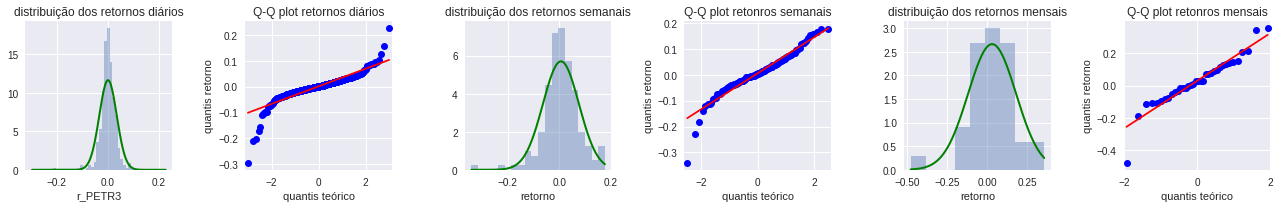

In [29]:
fig, ax = plt.subplots(1, 6 , figsize=(18,3))

r_range = np.linspace(min( retornos['r_'+codigo]), max( retornos['r_'+codigo]), num=1000)
# histograma diário
sns.distplot( retornos['r_'+codigo], kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title('distribuição dos retornos diários')#, fontsize=12)
ax[0].plot(r_range, stats.norm.pdf(r_range, loc=r_media, scale=r_desviopadrao) ,#
           'g', lw=2,label=f'N({media:.2f}, {variancia:.4f})')
# Q-Q plot diário
qq1 = sm.qqplot( retornos['r_'+codigo].values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot retornos diários')#, fontsize = 12)
ax[1].set(xlabel = 'quantis teórico', ylabel = 'quantis retorno')

##semanal
r_range = np.linspace(min(weekly_returns['retorno']), max(weekly_returns['retorno']), num=1000)
w_m = weekly_returns['retorno'].mean() 
w_s = weekly_returns['retorno'].std()

# histograma semanal
sns.distplot(weekly_returns['retorno'] , kde=False, norm_hist=True, ax=ax[2])
ax[2].set_title('distribuição dos retornos semanais')#, fontsize=12)
ax[2].plot(r_range, stats.norm.pdf(r_range, loc= w_m, scale= w_s),
           'g', lw=2,label=f'N({w_m:.2f}, {w_s**2:.4f})')
# Q-Q plot semanal
qq2 = sm.qqplot(weekly_returns['retorno'].values, line='s', ax=ax[3])
ax[3].set_title('Q-Q plot retonros semanais')#, fontsize = 12)
ax[3].set(xlabel = 'quantis teórico', ylabel = 'quantis retorno')


##mensal
r_range = np.linspace(min(monthly_returns['retorno']), max(monthly_returns['retorno']), num=1000)
w_m = monthly_returns['retorno'].mean() 
w_s = monthly_returns['retorno'].std()

# histograma mensal
sns.distplot(monthly_returns['retorno'] , kde=False, norm_hist=True, ax=ax[4])
ax[4].set_title('distribuição dos retornos mensais')#, fontsize=12)
ax[4].plot(r_range, stats.norm.pdf(r_range, loc= w_m, scale= w_s),
           'g', lw=2,label=f'N({w_m:.2f}, {w_s**2:.4f})')
# Q-Q plot mensal
qq2 = sm.qqplot(monthly_returns['retorno'].values, line='s', ax=ax[5])
ax[5].set_title('Q-Q plot retonros mensais')#, fontsize = 12)
ax[5].set(xlabel = 'quantis teórico', ylabel = 'quantis retorno')

fig.tight_layout() 
fig.show()

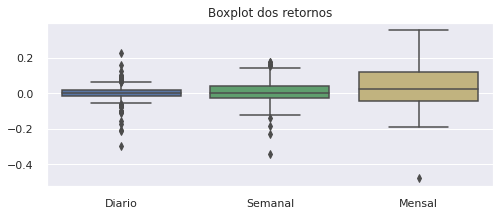

In [30]:
sns.set(rc={'figure.figsize':(8,3)})
sns.axes_style(style='darkgrid' ) 
ax = plt.gca()
ax.set_title('Boxplot dos retornos')  
sns.boxplot(data=[retornos['r_'+codigo], weekly_returns['retorno'], monthly_returns['retorno']], 
                palette=["#4c72B0", "#55A868", "#CCB974"], ax=ax)
ax.set_xticklabels(['Diario', 'Semanal', 'Mensal']);

comparação com ibov

In [31]:
print('-- Estatísticas do retorno diário')
tmp = [['Intervalo de datas' , str(min(retornos.index.date))+' ~ '+str(max(retornos.index.date)) , str(min(retornos.index.date))+' ~ '+str(max(retornos.index.date))],
       ['no. de observações' , retornos['r_'+codigo].shape[0] , retornos['r_ibov'].shape[0]],
       ['min', str(round( retornos['r_'+codigo].min()*100,3))+'%', str(round( retornos['r_ibov'].min()*100,3))+'%'],
       ['max', str(round( retornos['r_'+codigo].max()*100,3))+'%', str(round( retornos['r_ibov'].max()*100,3))+'%'],
       ['média', str(round( retornos['r_'+codigo].mean()*100,3))+'%', str(round( retornos['r_ibov'].mean()*100,3))+'%'],
       ['mediana', str(round( retornos['r_'+codigo].median()*100,3))+'%', str(round( retornos['r_ibov'].median()*100,3))+'%'],
       ['desvio padrão', str(round( retornos['r_'+codigo].std()*100,3))+'%', str(round( retornos['r_ibov'].std()*100,3))+'%'],
       ['assimetria', round( retornos['r_'+codigo].skew(),3), round( retornos['r_ibov'].skew(),3)],
       ['curtose', round( retornos['r_'+codigo].kurtosis(),3), round( retornos['r_ibov'].kurtosis(),3)],  
       ['retorno anualizado',str(round( retornos['r_'+codigo].mean()*252*100,2))+'%' , str(round( retornos['r_ibov'].mean()*252*100,2))+'%'],   
       ['dp anualizado',str(round( retornos['r_'+codigo].std()*np.sqrt(252)*100,2))+'%' , str(round( retornos['r_ibov'].std()*np.sqrt(252)*100,2))+'%'],
      ]       
vol = pd.DataFrame(tmp , columns=['tmp' , 'r_'+codigo , 'r_ibov'], index=[i[0] for i in tmp])
vol.drop('tmp',axis=1, inplace=True)
data_table.DataTable(vol , include_index=True ,num_rows_per_page=15)

-- Estatísticas do retorno diário


,r_PETR3,r_ibov
Intervalo de datas,2020-01-14 ~ 2023-01-13,2020-01-14 ~ 2023-01-13
no. de observações,747,747
min,-29.676%,-14.78%
max,22.755%,13.908%
média,0.139%,0.012%
mediana,0.089%,0.053%
desvio padrão,3.422%,1.952%
assimetria,-1.22,-0.989
curtose,15.611,14.916
retorno anualizado,34.97%,3.01%


In [32]:
#@markdown histogramas dos retornos diários

retornos.iplot(kind='histogram',
                  #subplots=True,
                  keys = ['r_'+codigo,'r_ibov'],
                  colors=['orange','purple'],
                  title='Histrograma dos retornos diários',
                  #theme="henanigans"
                  )

In [33]:
title = "Distribuição dos retornos ativo X ibov"

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Violin(meanline_visible=True, box_visible = True, y= retornos['r_'+codigo].values, name='retorno '+codigo)
    ,row=1, col=1)
fig.add_trace(
    go.Violin(meanline_visible=True, box_visible = True, y= retornos['r_ibov'], name='retorno ibov')
    ,row=1, col=2)
fig.update_layout(title_font_size=12 , width=800 , height=500 , showlegend=False,
               title={'text': title,'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},   ) 

fig.show()

In [34]:
stats.t.interval(alpha=0.98, df=len(retornos)-1,
              loc= retornos['r_ibov'].mean(),
              scale=stats.sem(retornos['r_ibov']))

(-0.001545192614528332, 0.0017842031070382082)

In [35]:
ipca = quandl.get('BCB/13522', start_date = min(retornos.index.date))
ipca.rename(columns={'Value': 'ipca'}, inplace=True)
cdi=quandl.get('BCB/12', start_date = min(retornos.index.date))
cdi.rename(columns={'Value': 'cdi'}, inplace=True)

In [36]:
ipca.tail(3)

,ipca
Date,
2022-10-31,6.47
2022-11-30,5.90
2022-12-31,5.79


In [37]:
cdi.tail(3)

,cdi
Date,
2023-01-10,0.050788
2023-01-11,0.050788
2023-01-12,0.050788


In [38]:
cdi.index=cdi.index.tz_localize(tz='America/Sao_Paulo')
ipca.index=ipca.index.tz_localize(tz='America/Sao_Paulo')

In [39]:
# @ markdown gráficos dos retornos mensais 

monthly_returns = pd.DataFrame()
monthly_returns[codigo] = preco['Preço'].resample('M').ffill().pct_change()
monthly_returns['Ibov'] = ibov['Preço'].resample('M').ffill().pct_change()
monthly_returns['CDI']  = cdi['cdi'].resample('M').ffill().pct_change()
monthly_returns['IPCA'] = ipca['ipca'].pct_change()

trace2 = (monthly_returns).iplot(title= 'Variação percentual mensal')

In [40]:
cum_returns = (monthly_returns + 1).cumprod() - 1
trace3 = cum_returns.iplot(title= 'Acumulado')

### correlação dos retornos com ativos do índice amplo

In [41]:
IBrA_rtrns = pd.DataFrame()
if codigo in IBrA : IBrA_rtrns = IBrA_preco.pct_change()  
else :
  IBrA_rtrns = (IBrA_preco.pct_change()).join(retornos['r_'+codigo],how='inner')
  IBrA_rtrns.rename(columns={'r_'+codigo : codigo+'.SA'}, inplace=True)
IBrA_rtrns.dropna(inplace=True)
#m=IBrA_rtrns.corr()

In [42]:
data_corr = pd.DataFrame(IBrA_rtrns.corr().loc[codigo+'.SA'])

clique na figura


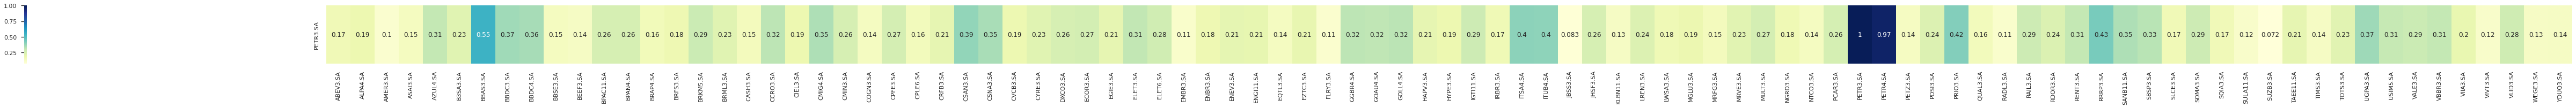

In [43]:
sns.set(rc = {'figure.figsize':(100,2)})
sns.heatmap(data_corr.T, annot = True, cmap = 'YlGnBu' , cbar_kws = dict(use_gridspec = False, location = "left"))
print('clique na figura')

### retorno esperado pelo CAPM 



In [44]:
## o join garante a coincidencia da datas
capm_data = ((cdi.join(retornos['r_'+codigo])).join(retornos['r_ibov'])).dropna()
capm_data.head(2)

,cdi,r_PETR3,r_ibov
Date,,,
2020-01-14 00:00:00-03:00,0.017089,-0.008102,0.002617
2020-01-15 00:00:00-03:00,0.017089,-0.022306,-0.010354


In [45]:
X = capm_data['r_ibov'] - capm_data['cdi']     # excesso retorno ativo
y = capm_data['r_'+codigo] - capm_data['cdi']  # excesso retorno indice 
c = sm.add_constant(X)
capm_model = sm.OLS(y, c)
result = capm_model.fit()
print(result.summary())
_, beta = result.params

expected_return = capm_data['cdi'].mean() + beta*X.mean()
print("Retorno diário esperado: " + str(expected_return))
monthly_return = expected_return * 21
print("Retorno mensal esperado: " + str(monthly_return))
yearly_return = monthly_return * 12
print("Retorno anual esperado : " + str(yearly_return))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     1558.
Date:                Mon, 16 Jan 2023   Prob (F-statistic):          1.15e-184
Time:                        11:07:18   Log-Likelihood:                 1801.0
No. Observations:                 746   AIC:                            -3598.
Df Residuals:                     744   BIC:                            -3589.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.001      5.841      0.0

### hedge

In [46]:
slope,intercept, r, pvalue, stderr = stats.linregress(x=retornos['r_ibov'], y=retornos['r_'+codigo])

print(f'A correlação entre os retornos é {r:.2f}')

line_x = np.linspace(retornos['r_ibov'].min(), retornos['r_ibov'].max(),100)
line_y = slope*line_x + intercept
trace1 = go.Scatter(x = line_x,y = line_y, mode = 'lines' )

trace2 = go.Scatter(x = retornos['r_ibov'], y=retornos['r_'+codigo] , mode ='markers')                   
                
layout = dict(title = f'O beta é {slope:.2f}, o alpha é {intercept:.2f} e   R²={r**2:.3f}',
              xaxis_title="Ibov",
              yaxis_title=codigo,
              height = 450,width = 620,
              showlegend=False,
              font = dict(size = 12),    )

data_trace = [trace1,trace2]
ply.iplot(go.Figure(data=data_trace , layout=layout))

A correlação entre os retornos é 0.79


In [47]:
# beta hedge
""" 
Portfolio managers design factor models that tell them how to balance a portfolio to earn alpha. 
Because alpha is how managers get paid, they only want exposure to their factors. 
Beta hedging removes the part of returns driven by the market and leaves only the returns driven by the factors.
"""


retornos[codigo+"+Hedge"] = -1 * slope * retornos['r_ibov']+ retornos['r_'+codigo]
retornos.iplot(   keys = ['r_'+codigo,'r_ibov',codigo+"+Hedge"],
                  colors=['orange','purple', 'red'],
                  title='Retornos diários' )


In [48]:
P = retornos[codigo+"+Hedge"].values
X = retornos['r_ibov'].values
alpha,beta,_,_,_ = stats.linregress(X, P)
print(f"Alpha: {alpha}")
print(f"Beta: {beta}")

Alpha: -1.1172969421948824e-15
Beta: 0.001222353889208637


#Volatilidade

##Volatilidade Condicional

Garch(1,1): a variância condicional é $\sigma_n^2 = \omega + \alpha r_{n-1}^2 + \beta\sigma_{n-1}^2 $, as letras gregas são parâmetros estimados (por máx. verossimilhamça) do modelo, $r$ é retorno e $\sigma^2$ variância.  Os parâmetros:  $\omega = (1-\alpha-\beta)\cdot(\text{var de longo prazo})$, que é uma "reversão a média": $\sigma_{\infty}^2\to \text{VLP}$ com velocidade $1-\alpha-\beta$; $\alpha$ é o peso dos retornos  mais recentes, desde que $\alpha,\beta,\omega\geq 0$ e $\alpha+\beta<1$; $\beta$ é velocidade do  decaimento para as volatilidades mais recentes. 

Quando $\omega=0,\alpha=1-\lambda, \beta=\lambda$ é o ewma: $ (1-\lambda) r_{n-1}^2 + \lambda \sigma_{n-1}^2$


In [49]:
#@title ####   EWMA
#@markdown fator de decaimento para ewma:
Lambda=0.94 #@param {type:"number"}


In [50]:
ewma = pd.DataFrame(data = 0, columns=['vol'],index=retornos.index)
ewma['vol'].iloc[0] = np.sqrt((retornos['r_'+codigo][0:4]**2).sum())
for t in range(1,len(retornos['r_'+codigo])):
    ewma.iloc[t] = np.sqrt((1-Lambda)*retornos['r_'+codigo].iloc[t-1]**2 + Lambda*ewma.iloc[t-1]**2)
ewma.tail(3)

,vol
Date,
2023-01-11 00:00:00-03:00,0.028450
2023-01-12 00:00:00-03:00,0.027762
2023-01-13 00:00:00-03:00,0.026949


In [51]:
######### 
tmp=pd.DataFrame()
tmp['ewma1'] = (retornos['r_'+codigo].ewm(alpha = 0.06, min_periods=4, adjust=False).std()).shift(1)
tmp['ewma2'] = ewma['vol']
tmp.iplot()
##########

In [52]:
#@title ####   GARCH(1,1)

!pip install -q arch
import scipy.optimize as spop

def garch_mle(params):
    mu    = params[0]
    omega = params[1]
    alpha = params[2]
    beta  = params[3]
    #variancia de longo prazo
    long_var =  (omega/(1 - alpha - beta))
    #volatilidade de longo prazo 
    long_run = np.sqrt(long_var*252)
    #volatilidade condicional
    resid = retornos['r_'+codigo] - mu
    realised = abs(resid)
    conditional = np.zeros(len(retornos['r_'+codigo]))
    conditional[0] =  long_run
    # GARCH
    for t in range(1,len(retornos['r_'+codigo])):
        conditional[t] = (omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)**(1/2)
    # np.log-verossimilhança
    likelihood = 1/((2*np.pi)**(1/2)*conditional)*np.exp(-realised**2/(2*conditional**2))
    np.log_likelihood = np.sum(np.log(likelihood))
    return -np.log_likelihood
### grach parametros
# maximização  np.log-verossimilhança 
res = spop.minimize(garch_mle , [media, variancia, 0, 0  ], method='Nelder-Mead')
    
params = res.x
G_mu     = res.x[0]
G_omega  = res.x[1]
G_alpha  = res.x[2]
G_beta   = res.x[3]
np.log_likelihood = -float(res.fun)
#print('np.log-verossim. '+str(round(np.log_likelihood, 4)))
###############################

print('Parâmetros do GARCH encontrados:')
print('mu '+str(round(G_mu, 6)))
print('omega '+str(round(G_omega, 6)))
print('alpha '+str(round(G_alpha, 6)))
print('beta  '+str(round(G_beta, 6)))


Parâmetros do GARCH encontrados:
mu 0.002496
omega 0.000315
alpha 0.28205
beta  0.376961


In [53]:
long_run = (G_omega/(1 - G_alpha - G_beta))**(1/2)
G_resid = retornos['r_'+codigo] - G_mu

conditional = pd.DataFrame(data = 0, columns=['vol'],index=retornos.index)
conditional['vol'].iloc[0] = long_run
for t in range(1,len(retornos['r_'+codigo])):
    conditional['vol'].iloc[t] = (G_omega + G_alpha*G_resid.iloc[t-1]**2 + G_beta*conditional.iloc[t-1]**2)**(1/2)
conditional.tail(3)

,vol
Date,
2023-01-11 00:00:00-03:00,0.023095
2023-01-12 00:00:00-03:00,0.023376
2023-01-13 00:00:00-03:00,0.022882


In [54]:
print('VOLATILIDADE:')
print('volatilidade diária de longo prazo '+str(round(long_run, 6)*100)+'%')
print('volatilidade de longo prazo anualizada '+str(round(long_run*np.sqrt(252), 6)*100)+'%')
print(' ')

VOLATILIDADE:
volatilidade diária de longo prazo 3.0402%
volatilidade de longo prazo anualizada 48.262%
 


In [55]:
from arch import arch_model
model = arch_model(retornos['r_'+codigo], mean='constant',vol='GARCH', p=1, q=1,dist='normal')
model_fitted = model.fit(disp='off')
print(model_fitted.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                r_PETR3   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1601.57
Distribution:                  Normal   AIC:                          -3195.13
Method:            Maximum Likelihood   BIC:                          -3176.67
                                        No. Observations:                  747
Date:                Mon, Jan 16 2023   Df Residuals:                      746
Time:                        11:07:34   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.3426e-03  9.648e-04      2.428  1.518e-02 [4.

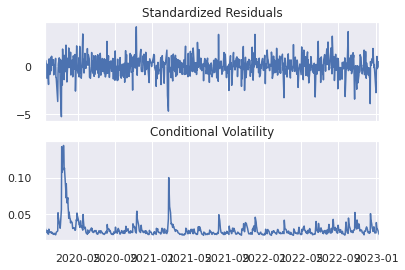

In [56]:
%matplotlib inline
model_fitted.plot();

In [57]:
model_forecast = model_fitted.forecast(horizon=5)

In [58]:
model_forecast.variance[-1:]

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2023-01-13 00:00:00-03:00,0.000481,0.000561,0.000627,0.000681,0.000726


In [59]:
######### 
tmp=pd.DataFrame()
tmp['garch1'] = conditional['vol']
tmp['garch2'] = model_fitted.conditional_volatility
tmp.iplot()
##########

In [60]:
vols = pd.DataFrame(columns=['ewma' , 'dp' , 'garch(1,1)' , 'longo prazo' , 'g-model'] , index = retornos.index)
vols['ewma'] = ewma['vol']
vols['dp'] = r_desviopadrao
vols['garch(1,1)'] = conditional['vol']
vols['longo prazo'] = long_run
vols['g-model']=model_fitted.conditional_volatility

In [61]:
vols.iplot()

In [62]:
vols.round(decimals=3).iloc[::-1].head(3)

,ewma,dp,"garch(1,1)",longo prazo,g-model
Date,,,,,
2023-01-13 00:00:00-03:00,0.027,0.034,0.023,0.03,0.022
2023-01-12 00:00:00-03:00,0.028,0.034,0.023,0.03,0.023
2023-01-11 00:00:00-03:00,0.028,0.034,0.023,0.03,0.024


Text(0.5, 1.0, 'Rolling Prediction')

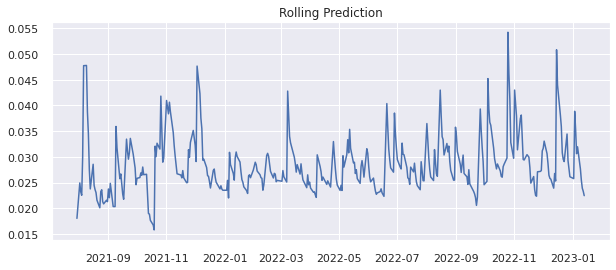

In [63]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = retornos['r_'+codigo][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=retornos['r_'+codigo].index[-365:])

fig,ax = plt.subplots(figsize=(10,4))
#ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')

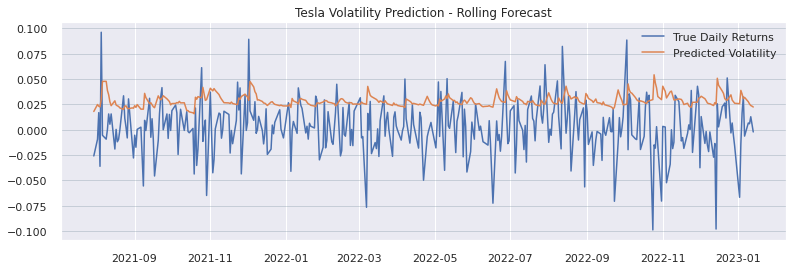

In [64]:
fig,ax = plt.subplots(figsize=(13,4))
ax.grid(which="major", axis='y', color='#758D99', alpha=0.3, zorder=1)
#ax.spines[['top','right']].set_visible(False)
plt.plot(retornos['r_'+codigo][-365:])
plt.plot(rolling_predictions)
plt.title('Tesla Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])


## Preço das opções por BS
Preço da Call $ = SN(d_1) - K e^{-rt}N(d_2)$ e 

Preço da Put $ = Ke^{-rt}N(-d_2)-SN(-d_1)$

$d_1 = \frac{\ln(\frac{S}{K}) + (r + \frac{\sigma^2}{2})t}{\sigma \cdot \sqrt{t}}$
e $d_2 = d_1 - \sigma \cdot \sqrt{t}$

S = Preço atual da ação; K = Preço de Strike; r = Taxa livre de risco (com capitalização composta); 
σ =Variância (anual) do retorno contínuo da ação; t = Prazo (em anos) até a data de vencimento;
N(d) = Probabilidade de que uma variável aleatória padronizada e com distribuição normal, seja menor ou igual a d


In [65]:
def call_option_price(S, E, T, rf, sigma):
    # d1 and d2 parameters
    d1 = (np.log(S / E) + (rf + sigma * sigma / 2.0) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S*stats.norm.cdf(d1)-E*np.exp(-rf*T)*stats.norm.cdf(d2)


def put_option_price(S, E, T, rf, sigma):
    # d1 and d2 parameters
    d1 = (np.log(S / E) + (rf + sigma * sigma / 2.0) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return -S*stats.norm.cdf(-d1)+E*np.exp(-rf*T)*stats.norm.cdf(-d2)


In [66]:
#data
vencimento = "2023-02-17"    #@param {type:"date"}
venc= datetime.strptime(vencimento, '%Y-%m-%d')

hoje= preco.index[-1]
res = np.busday_count(hoje.strftime('%Y-%m-%d'),
                      venc.strftime('%Y-%m-%d'))
t=res/252
# taxa livre risco
selic = quandl.get('BCB/432', start_date = inicio)
r =  np.log((selic.iloc[-1]/100).values[0]+1)
# preço
S = preco['Preço'].iloc[-1]      
# volatilidade
sigma = vols['dp'].iloc[-1]*np.sqrt(252)
sigma = vols['g-model'].iloc[-1]*np.sqrt(252)


preços teóricos para 'vencimento'

In [67]:
# strikes

mm = (preco['Preço'][-21:-1].dropna()).mean()  #preço médio
ss = (preco['Preço'][-21:-1].dropna()).std()   #dp do preço
Ss= mm-3*ss
Sa= mm-2*ss
Sb= mm-1*ss
Sc= mm+1*ss 
Sd= mm+2*ss
Se= mm+3*ss



bs_data = [
    [ '{:0.2f}'.format(Ss) , round(call_option_price(S,Ss, t, r, sigma),2)  ,round(put_option_price(S,Ss, t, r, sigma),2) ] ,
    [ '{:0.2f}'.format(Sa) , round(call_option_price(S,Sa, t, r, sigma),2)  ,round(put_option_price(S,Sa, t, r, sigma),2) ] ,
    [ '{:0.2f}'.format(Sb) , round(call_option_price(S,Sb, t, r, sigma),2)  ,round(put_option_price(S,Sb, t, r, sigma),2) ] ,
    [ '{:0.2f}'.format(mm) , round(call_option_price(S,mm, t, r, sigma),2)  ,round(put_option_price(S,mm, t, r, sigma),2) ] ,
    [ '{:0.2f}'.format(S)  , round(call_option_price(S,S , t, r, sigma),2)  ,round(put_option_price(S ,S, t, r, sigma),2) ] ,
    [ '{:0.2f}'.format(Sc) , round(call_option_price(S,Sc, t, r, sigma),2)  ,round(put_option_price(S,Sc, t, r, sigma),2) ] ,
    [ '{:0.2f}'.format(Sd) , round(call_option_price(S,Sd, t, r, sigma),2)  ,round(put_option_price(S,Sd, t, r, sigma),2) ] ,
    [ '{:0.2f}'.format(Se) , round(call_option_price(S,Se, t, r, sigma),2)  ,round(put_option_price(S,Se, t, r, sigma),2) ] 
]


BS = pd.DataFrame(bs_data , columns=['preço '+codigo, 'preço Call' , 'preço Put'] )
BS.style.hide_index()

preço PETR3,preço Call,preço Put
23.50,4.560000,0.070000
24.66,3.520000,0.180000
25.82,2.590000,0.400000
26.99,1.810000,0.760000
27.69,1.410000,1.060000
28.15,1.190000,1.290000
29.31,0.740000,1.990000
30.48,0.430000,2.830000


In [70]:
#@markdown preço teórico a partir de outros parâmetros
#@markdown usando BS e Monte Carlo

# preço
S=27.69 #@param {type:"number"}
print('preço  do ativo',S)

# data
vencimento = "2023-02-17"    #@param {type:"date"}
hoje= preco.index[-1]
venc= datetime.strptime(vencimento, '%Y-%m-%d')
res = np.busday_count(hoje.strftime('%Y-%m-%d'),
                      venc.strftime('%Y-%m-%d'))
t=res/252
print("vencimento em "+str(res)+" dias (",t,"anos)")

# strike
strike=27.23  #@param {type:"number"}

# selic
juros = 13.75 #@param {type:"number"}
r=np.log(juros/100+1)
# vol
volatilidade ='GARCH'  #@param ['GARCH' , 'EWMA' ,'Desvio Padrao' ]

if volatilidade == 'GARCH'  : 
	sigma = vols['g-model'].iloc[-1]*np.sqrt(252)
elif volatilidade == 'EWMA' : 
	sigma = vols['ewma'].iloc[-1]*np.sqrt(252) 
else : sigma = vols['ewma'].iloc[-1]*np.sqrt(252) 

print("Preços dos derivativos pelo modelo Black-Scholes")
print("Call: ", round(call_option_price(S, strike, t, r, sigma),2))
print("Put: ", round(put_option_price(S, strike, t, r, sigma),2))


preço  do ativo 27.69
vencimento em 25 dias ( 0.0992063492063492 anos)
Preços dos derivativos pelo modelo Black-Scholes
Call:  1.66
Put:  0.86


In [71]:

# Monte Carlo
def call_option_simulation(S0,E,T,rf,sigma,iterations):
	option_data = np.zeros([iterations, 2])
	rand = np.random.normal(0, 1, [1, iterations])
	#equation for the S(t) stock price
	stock_price = S0*np.exp(T*(r - 0.5*sigma**2)+sigma*np.sqrt(T)*rand)
	#we need S-E because we have to calculate the max(S-E,0)
	option_data[:,1] = stock_price - E   
	#average for the Monte-Carlo method
	#np.amax() returns the max(0,S-E) according to the formula
	average = np.sum(np.amax(option_data, axis=1))/float(iterations)
	#have to use the np.exp(-rT) discount factor
	return np.exp(-1.0*rf*T)*average
		
def put_option_simulation(S0,E,T,rf,sigma,iterations):
 option_data = np.zeros([iterations, 2])
 rand = np.random.normal(0, 1, [1, iterations])
 stock_price = S0*np.exp(T*(rf - 0.5*sigma**2)+sigma*np.sqrt(T)*rand)
 option_data[:,1] = E - stock_price
 average = np.sum(np.amax(option_data, axis=1))/float(iterations)
 return np.exp(-1.0*rf*T)*average


rodadas = 1000	#number of iterations in the Monte-Carlo simulation	
	

print("Preços dos derivativos por simulação Monte Carlo")
print("Call: ", round(call_option_simulation(S,strike,t,r,sigma,rodadas),2)) 
print("Put: ", round(put_option_simulation(S,strike,t,r,sigma,rodadas),2))

Preços dos derivativos por simulação Monte Carlo
Call:  1.7
Put:  0.83
